![uelogo2.png](attachment:uelogo2.png)
# <font color=#444444> Proyecto Parte I - Ciclo de Vida de los Modelos </font>
### <font color=#999999> Postgrado Onlie IA y Data Science 2020-2021 </font>  
**PROFESOR**: 
**David Kremer García**

Este notebook sirve de guía para el desarrollo del proyecto del módulo de Ciclo de Vida de los Modelos. 

# MNIST 
El set de datos de MNIST (Modified National Institute of Standards and Technology) es muy conocido en problemas de tratamiento y clasificación de imágenes con Machine Learning y Deep Learning y sirve como problema de prueba con el que se desarrollan y miden la mayoría de los algoritmos de clasificación de imágenes.

Consite en un set de imágenes con dígitos escritos a mano. Cada imagen, en blanco y negro y de 28x28 píxeles, contiene un dígito del 0 al 9, y está anotada (está identificado el dígito que contiene). 

![image.png](attachment:image.png)

El problema consiste en identificar, dada una imagen, a cual de los dígitos corresponde (es un problema de clasificación). El set de datos contiene 70.000 imágenes de dígitos escritos a mano, separadas en 60.000 de training y 10.000 de testing.

In [1]:
!pip install skorch

In [270]:
import math
import matplotlib.pyplot as plt
import matplotlib as mpl
import os
import numpy as np
import pickle as pkl
import pandas as pd
import random
import seaborn as sns
import skimage
import torch
import torch.nn as nn
import torchvision.datasets as datasets


from collections import defaultdict
from copy import deepcopy
from PIL import Image
from scipy import ndimage
from skimage import io
from skimage import transform, filters
from skimage.feature import hog
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import GridSearchCV, cross_validate
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.dummy import DummyClassifier
from skorch import NeuralNetClassifier
from torch.utils.data import Dataset
from tqdm.auto import tqdm

In [3]:
%matplotlib inline

RANDOM_STATE = 288
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

np.random.seed(RANDOM_STATE)
mpl.rc("figure", figsize=(12, 12))

# 1. Carga, visualización/exploración y reescalado de las imágenes (2 puntos)

Las imágenes están almacenadas en formato pickle. Antes de desarrollar el modelo, al igual que hemos hecho en ejercicios anteriores, hay que cargar los datos y conviene hacer una exploración y visualización de las imágenes.

Este apartado consiste en:
 - Cargar las imágenes desde el pickle y comprobar el número de filas y resolución del dataset
 - Visualizar una serie de imágenes
 - Reescalar las imágenes para que los valores de los datos estén entre -0.5 y 0.5

A fin de en el futuro no tener que incluir los datasets en un repo de git, las obtendremos vía online mediante **torchvision**.

In [4]:
MNIST_TRAIN = datasets.MNIST(root='./data', train=True, download=True, transform=None)
MNIST_TEST = datasets.MNIST(root='./data', train=False, download=True, transform=None)
MNIST_TRAIN, MNIST_TEST

(Dataset MNIST
     Number of datapoints: 60000
     Root location: ./data
     Split: Train,
 Dataset MNIST
     Number of datapoints: 10000
     Root location: ./data
     Split: Test)

In [5]:
tX_train, ty_train = MNIST_TRAIN.data[:].float(), MNIST_TRAIN.targets[:]
tX_test, ty_test = MNIST_TEST.data[:].float(), MNIST_TEST.targets[:]

In [6]:
X_train, y_train = tX_train.numpy(), ty_train.numpy()
print(X_train.shape, y_train.shape, (X_train.max(), X_train.min()))

(60000, 28, 28) (60000,) (255.0, 0.0)


El conjunto de entrenamiento contiene 60000 imágenes, es decir 60000 rows, y estas constan de una de resolución de 28x28 $px$. Además vemos que se trata de imágenes monocanal por lo que no será necesario realizar ninguna transformación en este aspecto.

In [7]:
def plot_img_sample_grid(data, size: int, labels: np.ndarray):
    nrows = ncols = size
    nsamples = nrows * ncols
    for i in range(nsamples):
        plt.subplot(nrows, ncols, (i+1))
        plt.imshow(data[i], cmap=plt.get_cmap('gray'))
        plt.axis('off')
        plt.title(labels[i])
    plt.show()


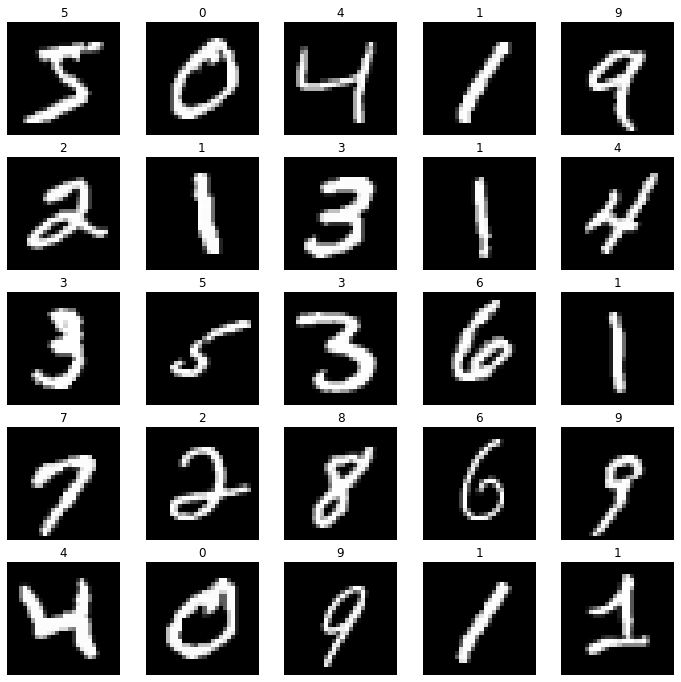

In [8]:
plot_img_sample_grid(X_train, 5, y_train)

In [9]:
X_test, y_test = tX_test.numpy(), ty_test.numpy()

print(X_test.shape, y_test.shape, (X_test.max(), X_test.min()))

(10000, 28, 28) (10000,) (255.0, 0.0)


El conjunto de test a su vez contiene 10000 rows con la misma resolución que el dataset de entrenamiento, 28x28 px

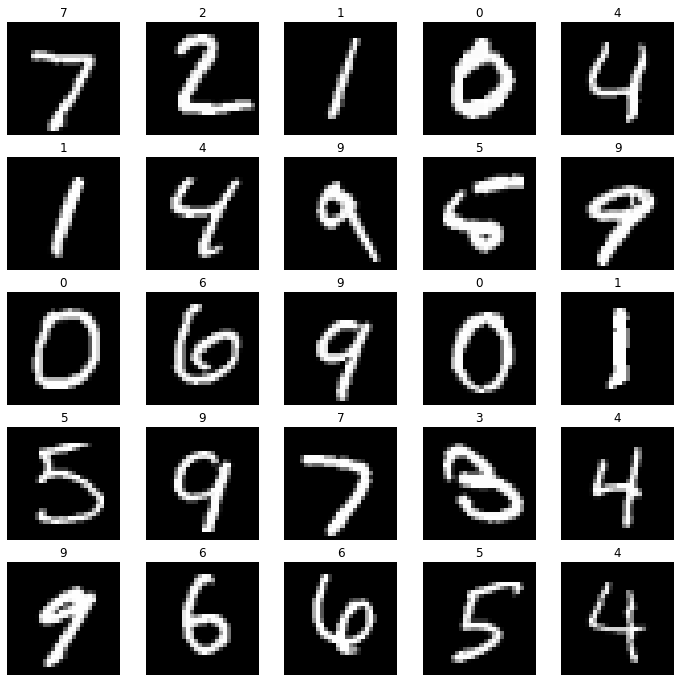

In [10]:
plot_img_sample_grid(X_test, 5, y_test)

Como se puede observar las imágenes contienen números manuscritos. Vamos a normalizar las imagenes re-escalando los valores en el rango $[-0.5, 0.5]$:

In [11]:
class Scaler(TransformerMixin, BaseEstimator):
    """Scale dataset in range [-0.5, 0.5]"""

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return (X / X.max()) - 0.5

    def fit_transform(self, X, y=None):
        return self.fit(X).transform(X)


In [12]:
scaler = Scaler()
X_train_n = scaler.fit_transform(X_train)
X_test_n = scaler.fit_transform(X_test)
print((X_train_n.min(), X_train_n.max()), (X_test_n.min(), X_test_n.max()))

(-0.5, 0.5) (-0.5, 0.5)


# 2. Entrenamiento de modelos de ML tradicionales con HOG features (2 puntos)

Para conseguir modelos mas robustos, podemos hacer uso de HOG features para procesar las imágenes de forma que obtengamos unas variables de entrada mas genéricas que los valores específicos de los píxeles.

Esta parte consiste en, al igual que hicimos en ejercicios anteriores:
 - Extraer las HOG features de las imágenes para obtener un dataset transformado con el que entrenar
 - Elegir 3 algoritmos de ML clásico (de scikit-learn) y entrenar modelos de clasificación con el dataset transformado 

In [13]:
class HOG(TransformerMixin, BaseEstimator):
    """
    Apply HOG to dataset using different pixels per 
    cell number in each iteration and return it flattened
    """
    def __init__(self, pixels_per_cell=(14,), orientations=8, cells_per_block=(1, 1), block_norm='L1'):
        
        self.pixels_per_cell = pixels_per_cell
        self._set_pixels_per_cell()
        self.orientations = orientations
        self.cells_per_block = cells_per_block
        self.block_norm = block_norm
        
    
    def _set_pixels_per_cell(self):
        if not isinstance(self.pixels_per_cell, (tuple, list)):
            switch = {
                float: lambda x: int(round(x)),
                str: lambda x: int(round(float(x))),
                int: lambda x: x,
            }
            try:
                func = switch[type(self.pixels_per_cell)]
            except KeyError:
                raise ValueError(f'Incorrect type {type(pixels_per_cell)} for ' \
                    'pixels_per_cell. Only (list, tuple, int, str, int, float' \
                    'are supported')
            value = func(self.pixels_per_cell)
            self.pixels_per_cell = (value,)
        

    def fit(self, X, y=None, **fit_params):
        return self
  
    def transform(self, X):
        hog_kwargs = {
            'orientations': self.orientations,
            'cells_per_block': self.cells_per_block,
            'block_norm': self.block_norm
        }
        hog_ftr = [np.concatenate([
                hog(xi, pixels_per_cell=(ppc, ppc), **hog_kwargs)[np.newaxis,:] 
                    for xi in X], axis=0) 
            for ppc in self.pixels_per_cell]

        return np.concatenate(hog_ftr, axis=1)
      
    def fit_transform(self, X, y=None, *fit_params):
        return self.fit(X).transform(X)
    

In [14]:
pixels_per_cell = [14,7,4]
X_train_hog = HOG(pixels_per_cell=pixels_per_cell).fit_transform(X_train_n)
X_test_hog =  HOG(pixels_per_cell=pixels_per_cell).fit_transform(X_test_n)

print(X_train_hog.shape, X_test_hog.shape)

(60000, 552) (10000, 552)


In [15]:
def benchmark_models(models):
    scores = defaultdict(dict)
    for name, Model in tqdm(models):
        model = Model(random_state=RANDOM_STATE)
        model.fit(X_train_hog, y_train)
        scores[name]['train'] = model.score(X_train_hog, y_train)
        scores[name]['test'] = model.score(X_test_hog, y_test)
        print((name, scores[name]['train'], scores[name]['test']))

    return scores

Escogeremos un modelo de cada família; ensemble, linear y svm

  0%|          | 0/3 [00:00<?, ?it/s]

('RandomForest', 1.0, 0.9772)


/home/Tiendeo/.envs/ue_master/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


('LogisticRegression', 0.98745, 0.979)
('SVC', 0.9959833333333333, 0.9867)
       RandomForest  LogisticRegression       SVC
train        1.0000             0.98745  0.995983
test         0.9772             0.97900  0.986700


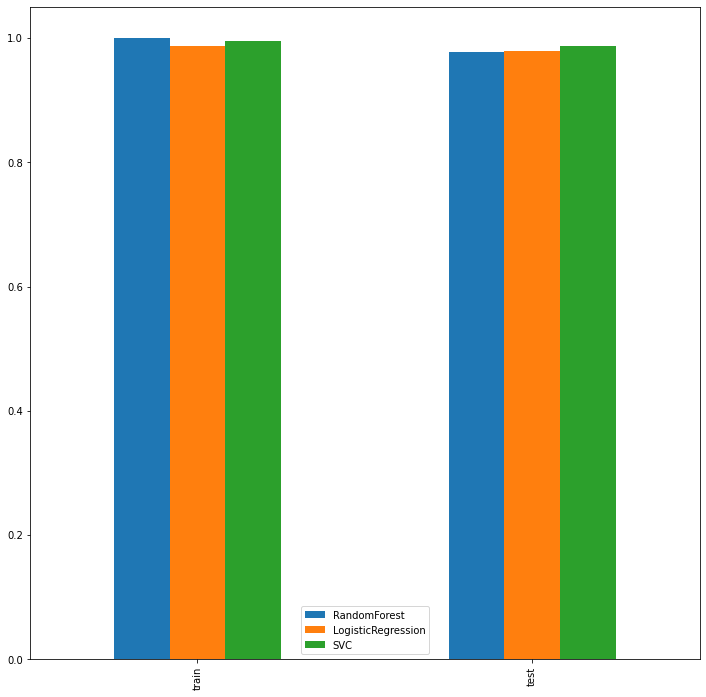

In [16]:
ml_models = [
    ('RandomForest', RandomForestClassifier),
    ('LogisticRegression', LogisticRegression),
    ('SVC', SVC)
]

scores = benchmark_models(ml_models)
scores_df = pd.DataFrame(scores)
print(scores_df)
scores_df.plot(kind='bar')
plt.show()

Vemos que con los hiperparámetros default el mejor modelo es la máquina de soporte vectorial. Con RandomForest se aprecia overfitting esto es debido a que es un modelo con bajo bias y alta varianza.

# 3.	Grid search de hiperparámetros de los modelos y HOG features (1 punto)

Para refinar los modelos entrenados en el apartado anterior, en este apartado el objetivo es:
- Desarrollar una pipeline de scikit-learn con las transformaciones realizadas (incluyendo HOG features) y los modelos desarrollados
- Hacer un grid search sobre esta pipeline para hacer una selección de los hiperparámetros los modelos y de los hiperparámetros de la transformación HOG

In [17]:
class Clf(BaseEstimator):
    """Base model used to host classifiers on GridSearchCV"""
    def __init__(self, estimator=DummyClassifier()):
        self.estimator = estimator

    def fit(self, X, y=None, **kwargs):
        self.estimator.fit(X, y)
        return self

    def predict(self, X, y=None):
        return self.estimator.predict(X)

    def predict_proba(self, X):
        return self.estimator.predict_proba(X)

    def score(self, X, y):
        return self.estimator.score(X, y)

In [18]:
ml_pipe = make_pipeline(Scaler(), HOG(), Clf(), )
ml_param_grid = [{
        'clf__estimator': [LogisticRegression()],
        'clf__estimator__solver': ['sag', 'saga'],
        'clf__estimator__max_iter': [100, 800], #default 100
        'clf__estimator__penalty': ['l2', 'none'], #default l2
        'hog__pixels_per_cell': [[14, 7, 4],]
    },{
        'clf__estimator': [RandomForestClassifier()],
        'clf__estimator__criterion': ['entropy', 'gini'], #default gini
        'clf__estimator__n_estimators': [100, 150], #default 100
        'hog__pixels_per_cell': [[14, 7, 4],]
    },{
        'clf__estimator': [SVC()],
        'clf__estimator__C': [1., 10.], # default 1.
        'clf__estimator__gamma': ['scale', 'auto'], # default scale
        'hog__pixels_per_cell': [[14, 7, 4],]
    }]

In [19]:
checkpoints = []

ml_gs_filename = 'ml_gs.pkl'
checkpoints.append(ml_gs_filename)
try:
    with open(ml_gs_filename, 'rb') as fp:
        ml_gs = pkl.load(fp)
except FileNotFoundError:
    ml_gs = GridSearchCV(ml_pipe, ml_param_grid, 
        cv=3, n_jobs=2, verbose=4, scoring='accuracy', return_train_score=True)
    ml_gs.fit(X_train, y_train)
    with open(ml_gs_filename, 'wb') as fp:
        pkl.dump(ml_gs, fp)

Fitting 3 folds for each of 16 candidates, totalling 48 fits


In [20]:
ml_results = pd.DataFrame(ml_gs.cv_results_).sort_values('rank_test_score').reset_index()
ml_results[['param_clf__estimator', 'mean_test_score', 'mean_train_score']][:3]

,param_clf__estimator,mean_test_score,mean_train_score
0,SVC(C=10.0),0.984433,0.999975
1,SVC(C=10.0),0.983550,0.995933
2,SVC(C=10.0),0.976150,0.983333


In [21]:
ml_gs.best_params_

{'clf__estimator': SVC(C=10.0),
 'clf__estimator__C': 10.0,
 'clf__estimator__gamma': 'scale',
 'hog__pixels_per_cell': [14, 7, 4]}

# 4. Diseño de red neuronal “fully connected”, no convolucional. (1 punto)

Como hemos visto en la sesión de Deep Learning, los modelos de Deep Learning son capaces de "capturar" features a partir de los datos. 

El objetivo de esta sección es:
- Construir una red neuronal no convolucional que tenga como input una imágen y como output la probabilidad asociada a cada clase (dígitos 0-9)
- Comprobar que la red definida funciona haciendo un forward pass (sin entrenarla)

Movemos los tensores a la GPU si es posible

In [22]:
if DEVICE == 'cuda':
    for subset in (tX_train, ty_train, tX_test, ty_test):
        subset = subset.cuda()

In [381]:
class MLPModule(nn.Module):
    """ Multi Layer Perceptron """
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Flatten(),
            nn.Dropout(0.5),
            nn.Linear(28*28, 128),
            nn.LeakyReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, 64),
            nn.Dropout(0.5),
            nn.Linear(64, 10),
            nn.LogSoftmax(dim=1)
        )
        
    def forward(self, X):
        return self.network(X)
    
def init_f(forw):
    """ Initialize NN weights using xavier normal"""
    for nam, param in forw.named_parameters():
        if 'weight' in nam:
            torch.nn.init.xavier_normal_(param) 
        else:
            param.data.fill_(0.01)

In [24]:
mlp_net = NeuralNetClassifier(
    MLPModule,
    max_epochs=50,
    iterator_train__num_workers=4,
    iterator_valid__num_workers=4,
    lr=1e-3,
    batch_size=64,
    optimizer=torch.optim.Adam,
    criterion=nn.CrossEntropyLoss,
    device=DEVICE,
    warm_start=True
    )
mlp_net.initialize()
mlp_net.forward(tX_train).shape

torch.Size([60000, 10])

In [25]:
for name, param in mlp_net.module_.named_parameters():
    print(name, param.shape)

network.2.weight torch.Size([128, 784])
network.2.bias torch.Size([128])
network.5.weight torch.Size([64, 128])
network.5.bias torch.Size([64])
network.7.weight torch.Size([10, 64])
network.7.bias torch.Size([10])


# 5. Entrenamiento red neuronal “fully connected”. (0,5 puntos)

El objetivo de esta sección es entrenar la red definida en el apartado anterior y comprobar su rendimiento en el set de testing.

In [26]:
mlp_pipe = Pipeline([
    ('scaler', Scaler()),
    ('net', mlp_net),
])

In [27]:
mlp_filename = 'mlp.pkl'
checkpoints.append(mlp_filename)

try:
    with open(mlp_filename, 'rb') as fp:
        mlp_pipe = pkl.load(fp)
except FileNotFoundError:
    torch.manual_seed(RANDOM_STATE)
    init_f(mlp_net.module_)
    mlp_pipe.fit(tX_train.unsqueeze(1), ty_train)
    with open(mlp_filename, 'wb') as fp:
        pkl.dump(mlp_pipe, fp)

  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        1.1698       0.8755        0.4449  2.1520
      2        0.7429       0.8997        0.3728  2.0935
      3        0.6700       0.9123        0.3224  2.1225
      4        0.6352       0.9157        0.2939  2.1555
      5        0.6011       0.9240        0.2746  2.1438
      6        0.5712       0.9234        0.2677  2.1290
      7        0.5570       0.9347        0.2416  2.1611
      8        0.5421       0.9312        0.2461  2.1091
      9        0.5203       0.9324        0.2334  2.1005
     10        0.5084       0.9357        0.2261  2.0981
     11        0.5029       0.9368        0.2189  2.1110
     12        0.4929       0.9438        0.2061  2.1236
     13        0.4752       0.9395        0.2144  2.1263
     14        0.4672       0.9431        0.2010  2.1253
     15        0.4631       0.9472        0.1942  2.1414
     16        0.4526       0.9

In [28]:
mlp_pipe.score(tX_train.unsqueeze(1), ty_train), mlp_pipe.score(tX_test.unsqueeze(1), ty_test)

(0.9642, 0.9608)

# 6. Diseño de red neuronal convolucional. (1 punto)

Como hemos visto en la sesión de Deep Learning, las redes convolucionales presentan mejores resultados para la clasificación de imágenes, ya que capturan mejor la estructura y correlación entre píxeles cercanos. 

El objetivo de esta sección es:
- Construir una red neuronal convolucional que tenga como input una imágen y como output la probabilidad asociada a cada clase (dígitos 0-9)
- Comprobar que la red definida funciona haciendo un forward pass (sin entrenarla)

In [366]:
class Unsqueeze(TransformerMixin, BaseEstimator):

    def fit(self, X, y=None):
        return self

    def transform(self, X):        
        return X.unsqueeze(1)

$$
Cálculo\ de\ los\ pixels\ resultantes\ de\ la\ capa\ de\ convolución \\
h = w = \frac{1 + (w_0 - n + 2p)}{s} \\
C_{out} = h \cdot w \cdot C_{out}\\
\\
Cálculo\ de\ los\ pixels\ resultantes\ de\ la\ transformación\ de\ MaxPooling \\
P_{out} = \frac{w_0+2·p−d·(n−1)−1}{s} +1 \\
$$

In [31]:
class NNetModule(nn.Module):
    """ Convolutional Neuronal Network"""
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),  # w = h = 1 + (32 - 3 + 2·1 ) / 1 = 28
            nn.LeakyReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1), # w = h = 1 + (28 - 3 + 2·1 ) / 1 = 28
            nn.MaxPool2d(kernel_size=2, stride=2), # w = h = ((28 + 2·0 - 1 · (2-1)-1)   / 2)+1 = 13 + 1 = 14
            nn.LeakyReLU(),
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1), # w = h = 1 + (28 - 3 + 2·1 ) / 1 = 28
            nn.MaxPool2d(kernel_size=2, stride=2), # w = h = ((14 + 2·0 - 1 · (2-1)-1)   / 2)+1 = 6 + 1 = 7
            nn.LeakyReLU(),
            nn.Flatten(), 
            nn.Dropout(0.5),
            nn.Linear(128 * 7 * 7, 128), # L_in = F_out = d · h · w = 128 · 7 · 7 = 6272
            nn.LeakyReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, 64),
            nn.Dropout(0.5),
            nn.Linear(64, 10),
            nn.LogSoftmax(dim=1)
        )
        
    def forward(self, X):
        return self.network(X)
        
cnv_net = NeuralNetClassifier(
    NNetModule,
    max_epochs=500,
    iterator_train__num_workers=4,
    iterator_valid__num_workers=4,
    lr=1e-3,
    batch_size=64,
    optimizer=torch.optim.Adam,
    criterion=nn.CrossEntropyLoss,
    device=DEVICE,
    warm_start=True
)
cnv_net.initialize()
cnv_net.forward(make_pipeline(Unsqueeze(), Scaler()).fit_transform(tX_train)).shape

torch.Size([60000, 10])

In [32]:
for name, param in cnv_net.module_.named_parameters():
    print(name, param.shape)

network.0.weight torch.Size([32, 1, 3, 3])
network.0.bias torch.Size([32])
network.2.weight torch.Size([64, 32, 3, 3])
network.2.bias torch.Size([64])
network.5.weight torch.Size([128, 64, 3, 3])
network.5.bias torch.Size([128])
network.10.weight torch.Size([128, 6272])
network.10.bias torch.Size([128])
network.13.weight torch.Size([64, 128])
network.13.bias torch.Size([64])
network.15.weight torch.Size([10, 64])
network.15.bias torch.Size([10])


# 7. Entrenamiento red neuronal convolucional. (0,5 puntos)

El objetivo de esta sección es entrenar la red definida en el apartado anterior y comprobar su rendimiento en el set de testing.

In [33]:
cnv_pipe = Pipeline([
    ('scaler', Scaler()),
    ('ocbw', Unsqueeze()),
    ('net', cnv_net),
])

In [34]:
cnv_filename = 'cnv.pkl'
checkpoints.append(cnv_filename)
try:
    with open(cnv_filename, 'rb') as fp:
        cnv_pipe = pkl.load(fp)
except FileNotFoundError:
    init_f(cnv_net.module_)
    torch.manual_seed(RANDOM_STATE)
    cnv_pipe.fit(tX_train, ty_train)
    with open(cnv_filename, 'wb') as fp:
        pkl.dump(cnv_pipe, fp)

  epoch    train_loss    valid_acc    valid_loss      dur
-------  ------------  -----------  ------------  -------
      1        0.3822       0.9800        0.0752  42.9906
      2        0.1121       0.9878        0.0470  42.7710
      3        0.0832       0.9898        0.0387  43.1463
      4        0.0721       0.9901        0.0375  43.0349
      5        0.0638       0.9887        0.0448  49.7267
      6        0.0535       0.9907        0.0399  43.8867
      7        0.0516       0.9898        0.0359  42.9597
      8        0.0476       0.9897        0.0409  42.7444
      9        0.0432       0.9901        0.0381  43.3472
     10        0.0408       0.9892        0.0484  43.0658
     11        0.0410       0.9900        0.0438  43.0749
     12        0.0352       0.9919        0.0312  43.2832
     13        0.0343       0.9912        0.0404  43.0602
     14        0.0351       0.9904        0.0408  43.2070
     15        0.0282       0.9914        0.0422  43.3418
     16       

    132        0.0136       0.9935        0.0654  146.0860
    133        0.0166       0.9936        0.0674  141.8719
    134        0.0169       0.9916        0.0648  133.5627
    135        0.0171       0.9918        0.0731  144.1956
    136        0.0137       0.9938        0.0505  145.3944
    137        0.0151       0.9932        0.0756  140.9637
    138        0.0167       0.9932        0.0804  145.3658
    139        0.0139       0.9925        0.0824  152.1281
    140        0.0184       0.9926        0.0619  139.8764
    141        0.0215       0.9925        0.0583  144.3898
    142        0.0147       0.9924        0.0781  151.3831
    143        0.0175       0.9932        0.0864  152.1984
    144        0.0157       0.9933        0.0721  157.7396
    145        0.0173       0.9928        0.0861  146.2911
    146        0.0147       0.9917        0.0695  157.1625
    147        0.0157       0.9914        0.0635  149.0029
    148        0.0136       0.9924        0.0860  144.96

    271        0.0292       0.9931        0.0800  166.8865
    272        0.0219       0.9922        0.0892  165.7284
    273        0.0241       0.9926        0.1446  172.2950
    274        0.0252       0.9920        0.1170  169.5934
    275        0.0260       0.9933        0.1335  171.8624
    276        0.0206       0.9929        0.1132  173.2330
    277        0.0217       0.9931        0.1573  173.0513
    278        0.0213       0.9933        0.1143  169.7774
    279        0.0210       0.9937        0.1308  167.3728
    280        0.0217       0.9934        0.1468  170.1828
    281        0.0259       0.9923        0.0703  167.4696
    282        0.0227       0.9927        0.1117  169.0155
    283        0.0215       0.9923        0.0868  163.5358
    284        0.0195       0.9930        0.1157  168.7900
    285        0.0241       0.9924        0.1332  168.5914
    286        0.0259       0.9928        0.0896  166.6070
    287        0.0220       0.9925        0.1821  166.52

    410        0.0319       0.9937        0.0965  168.3475
    411        0.0289       0.9926        0.1411  167.9679
    412        0.0252       0.9922        0.1678  163.6310
    413        0.0361       0.9927        0.0716  160.4149
    414        0.0278       0.9903        0.0718  158.8142
    415        0.0358       0.9923        0.1710  163.9203
    416        0.0298       0.9923        0.1560  165.2902
    417        0.0268       0.9922        0.0710  167.5070
    418        0.0413       0.9925        0.0913  153.0003
    419        0.0357       0.9919        0.1192  159.7027
    420        0.0336       0.9911        0.0562  164.6874
    421        0.0295       0.9923        0.0897  162.3263
    422        0.0378       0.9930        0.0617  162.3287
    423        0.0299       0.9922        0.1653  165.6047
    424        0.0370       0.9928        0.1147  162.9608
    425        0.0346       0.9922        0.1127  166.4209
    426        0.0320       0.9922        0.1383  184.08

In [35]:
cnv_pipe.score(tX_train, ty_train), cnv_pipe.score(tX_test, ty_test)

(0.9984833333333333, 0.995)

# 8. Comparativa de métricas y matrices de confusión entre todos los modelos entrenados de ML y DL. (1 punto)

El objetivo de esta sección es comparar los resultados obtenidos entre los distintos modelos (ML, NN, CNN). 

En particular:
- Mostrar la matriz de confusión para cada modelo.
- Elegir y dibujar algunas métricas adicionales. 
- Describir las conclusiones.

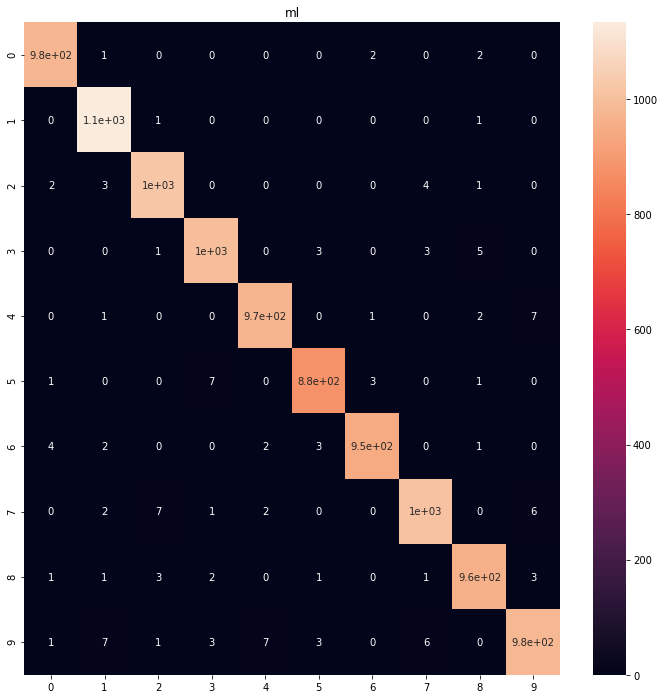

              precision    recall  f1-score   support

           0     0.9909    0.9949    0.9929       980
           1     0.9852    0.9982    0.9917      1135
           2     0.9874    0.9903    0.9889      1032
           3     0.9871    0.9881    0.9876      1010
           4     0.9888    0.9888    0.9888       982
           5     0.9888    0.9865    0.9877       892
           6     0.9937    0.9875    0.9906       958
           7     0.9863    0.9825    0.9844      1028
           8     0.9867    0.9877    0.9872       974
           9     0.9840    0.9722    0.9781      1009

    accuracy                         0.9878     10000
   macro avg     0.9879    0.9877    0.9878     10000
weighted avg     0.9878    0.9878    0.9878     10000



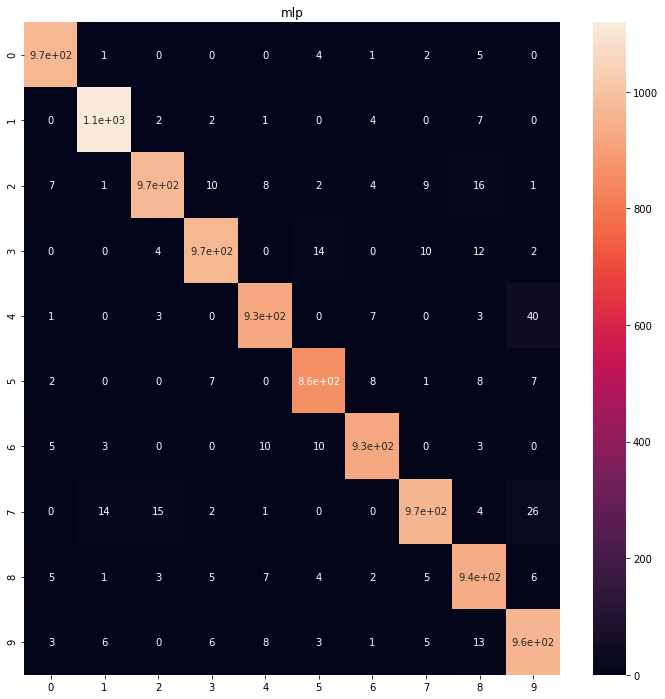

              precision    recall  f1-score   support

           0     0.9768    0.9867    0.9817       980
           1     0.9773    0.9859    0.9816      1135
           2     0.9730    0.9438    0.9582      1032
           3     0.9680    0.9584    0.9632      1010
           4     0.9637    0.9450    0.9542       982
           5     0.9587    0.9630    0.9609       892
           6     0.9717    0.9676    0.9697       958
           7     0.9679    0.9397    0.9536      1028
           8     0.9295    0.9610    0.9450       974
           9     0.9216    0.9554    0.9382      1009

    accuracy                         0.9608     10000
   macro avg     0.9608    0.9607    0.9606     10000
weighted avg     0.9611    0.9608    0.9608     10000



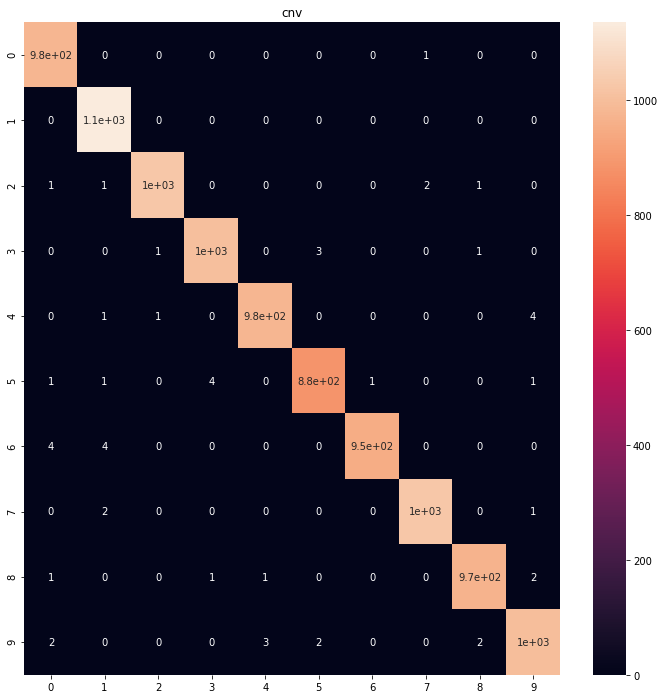

              precision    recall  f1-score   support

           0     0.9909    0.9990    0.9949       980
           1     0.9921    1.0000    0.9961      1135
           2     0.9981    0.9952    0.9966      1032
           3     0.9950    0.9950    0.9950      1010
           4     0.9959    0.9939    0.9949       982
           5     0.9944    0.9910    0.9927       892
           6     0.9989    0.9916    0.9953       958
           7     0.9971    0.9971    0.9971      1028
           8     0.9959    0.9949    0.9954       974
           9     0.9921    0.9911    0.9916      1009

    accuracy                         0.9950     10000
   macro avg     0.9950    0.9949    0.9950     10000
weighted avg     0.9950    0.9950    0.9950     10000



In [271]:
best_models = [(x, name) for x, name in [(ml_gs.best_estimator_, 'ml'), (mlp_pipe, 'mlp'), (cnv_pipe, 'cnv')]]

for estimator, name in best_models:
    y_hat = estimator.predict(tX_test)
    cf_matrix = confusion_matrix(ty_test, y_hat)
    sns.heatmap(cf_matrix, annot=True)
    plt.title(name)
    plt.show()
    print(classification_report(ty_test, y_hat, digits=4))

### Conclusiones

El mejor modelo sería la red neuronal convolucional, pero les sigue muy de cerca la máquina de soporte vectorial. Cabe que destacar que me ha sido muy difícil entrenar la CNN debido a los grandes recursos computacionales que requiere, los cuales provocaban leaks continuos de memoria. Este hecho me llevado a plantear que en realidad dependiendo de los recursos que se posean y el threshold de accuracy definido quizás es mejor obtar por un modelo de ML en vez de una CNN

# 9. Comparativa de la robustez de los distintos modelos entrenados frente a la translación horizontal de los dígitos. (0,5 puntos)

El objetivo de esta sección es:
- Probar el rendimiento de los modelos entrenados sobre distintas transformaciones del set de testing (por ejemplo, sobre translaciones horizontales como se mostró en las sesiones de este módulo).
- Dibujar las gráficas correspondientes de acierto frente a la magnitud de la transformación (por ej. cantidad de píxeles desplazados).
- Describir las conclusiones.

In [48]:
tr_W = np.array(list(range(-50, 50, 5)))
X_test_Ws = [np.roll(tX_test, i, axis=2) for i in tr_W]
tX_test_Ws = [torch.from_numpy(x) for x in X_test_Ws]
tX_test_Ws[0].shape

torch.Size([10000, 28, 28])

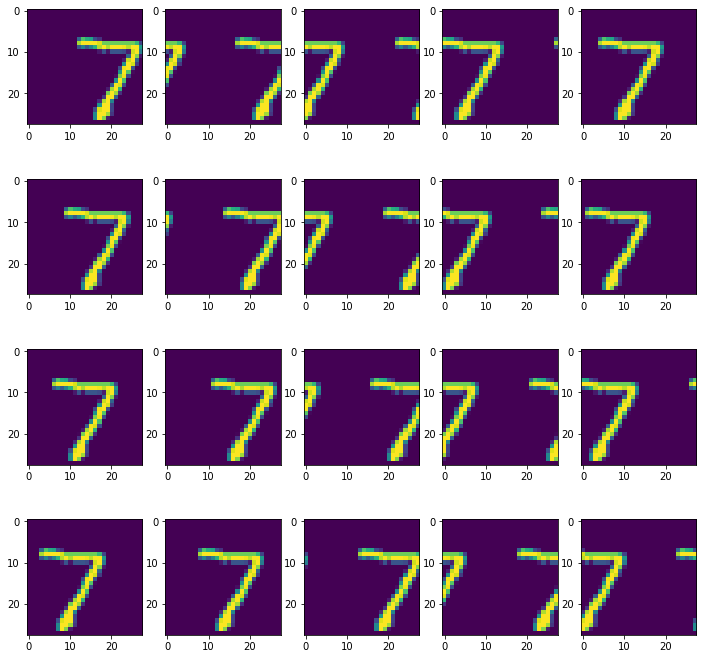

In [49]:
im = io.imshow_collection([xi[0,:,:] for xi in tX_test_Ws])

In [50]:
ml_scores = []
mlp_scores = []
cnv_scores = []

for translation in tX_test_Ws:
    ml_scores.append(ml_gs.score(translation, ty_test))
    mlp_scores.append(mlp_pipe.score(translation, ty_test))
    cnv_scores.append(cnv_pipe.score(translation, ty_test))


all_scores = pd.DataFrame(data={
    'ml': ml_scores,
    'mlp': mlp_scores,
    'cnv': cnv_scores
}, index=tr_W)

<AxesSubplot:>

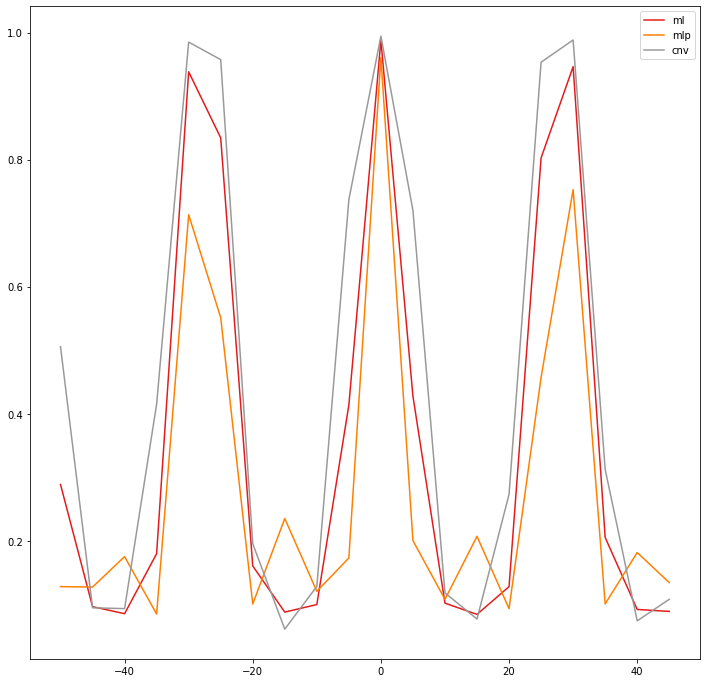

In [51]:
all_scores.plot(colormap='Set1')

In [52]:
all_scores.describe()

,ml,mlp,cnv
count,20.000000,20.000000,20.000000
mean,0.352715,0.280555,0.439770
std,0.342380,0.260020,0.374789
min,0.084600,0.085200,0.061400
25%,0.095700,0.117750,0.104975
50%,0.170500,0.174450,0.293100
75%,0.521600,0.290950,0.791075
max,0.987800,0.960800,0.994300


#### Conclusiones 

El modelo más robusto a las translaciones es sin duda la red convolucional con un promedio de 0.44 de $accuracy$. Como es normal, en las translaciones en las que el número queda divido en ambos lados de la imagen la accuracy caen notablemente en todos los modelos.

# 10. Desarrollo de una función de preprocesado / reescalado para input al modelo, y exportación del modelo escogido. (0,5 puntos)


El objetiivo de esta sección es el de preparar el modelo para su despliegue en la Parte II de la práctica.

Para ello, habrá que:
- Seleccionar el mejor modelo entre los probados (típicamente, debería ser la CNN).
- Construir una función de preprocesado (o una pipeline de scikit-learn, o equivale) que transforme una imágen genérica en algo consumible por el modelo, replicando también las transformaciones hechas durante el entrenamiento.
- Exportar el modelo y la pipeline en un formato importable desde una aplicación python, como por ejemplo un fichero “.pt” (pytorch) con los pesos de la red neuronal, o una de la pipeline entera a un fichero “.pkl” (pickle).


Previamente a la exportación del modelo lo entrenaremos con los datos de testing y las translaciones

In [362]:
cnv_pipe.fit(tX_test, ty_test)

Pipeline(steps=[('scaler', Scaler()), ('ocbw', OneChannel()),
                ('net',
                 <class 'skorch.classifier.NeuralNetClassifier'>[initialized](
  module_=NNetModule(
    (network): Sequential(
      (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): LeakyReLU(negative_slope=0.01)
      (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): MaxPool2d(kernel_size=2,...
      (8): Flatten(start_dim=1, end_dim=-1)
      (9): Dropout(p=0.5, inplace=False)
      (10): Linear(in_features=6272, out_features=128, bias=True)
      (11): LeakyReLU(negative_slope=0.01)
      (12): Dropout(p=0.5, inplace=False)
      (13): Linear(in_features=128, out_features=64, bias=True)
      (14): Dropout(p=0.5, inplace=False)
      (15): Linear(in_features=64, out_features=10, bias=True)
      (16): LogSoftmax(dim=1)
    )
  ),
))])

In [327]:
cnv_pipe.score(tX_train, ty_train), cnv_pipe.score(tX_test, ty_test)

(0.9944166666666666, 0.9982)

In [380]:
class Preprocess(TransformerMixin, BaseEstimator):
    
    def fit(self, X, y=None, **fit_params):
        return self
    
    def transform(self, X):
        desired_size = 28
        im = X.convert('L')
        old_size = im.size
        ratio = float(desired_size)/max(old_size)
        new_size = tuple([int(x*ratio) for x in old_size])
        height = width = (desired_size-new_size[0]) // 2
        
        im = im.resize(new_size)
        
        new_im = Image.new("L", (desired_size, desired_size), color='white')
        new_im.paste(im, (height, width))

        return torch.from_numpy(np.array(new_im)).reshape(1, 28, 28).float()

In [364]:
final_pipe = deepcopy(cnv_pipe)
final_pipe.steps.insert(0,['preprocessing', Preprocess()])

In [370]:
final_pipe.steps

[['preprocessing', Preprocess()],
 ('scaler', Scaler()),
 ('unsquezze', Unsqueeze()),
 ('net',
  <class 'skorch.classifier.NeuralNetClassifier'>[initialized](
    module_=NNetModule(
      (network): Sequential(
        (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): LeakyReLU(negative_slope=0.01)
        (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        (4): LeakyReLU(negative_slope=0.01)
        (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        (7): LeakyReLU(negative_slope=0.01)
        (8): Flatten(start_dim=1, end_dim=-1)
        (9): Dropout(p=0.5, inplace=False)
        (10): Linear(in_features=6272, out_features=128, bias=True)
        (11): LeakyReLU(negative_slope=0.01)
        (12): Dropout(p=0.5, inplace=Fals

Vamos a probar el pipeline con la función de pre-procesado

In [371]:
img = Image.fromarray(np.uint8(X_test[30]))
img

In [372]:
final_pipe.predict(img)

array([3])

In [360]:
with open('pipeline.pkl', 'wb') as fp:
    pkl.dump(final_pipe, fp)

In [361]:
for checkpoint in checkpoints:
    os.remove(checkpoint)
checkpoints = []

#### Bibliografía

https://scikit-learn.org/stable/modules/classes.html

https://pytorch.org/docs/stable/index.html

https://skorch.readthedocs.io/en/stable/

https://pandas.pydata.org/docs/reference/index.html

https://numpy.org/doc/stable/reference/index.html